# Imports

In [1]:
import os
import numpy as np

import pandas as pd
from pandas import Series, DataFrame

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

In [2]:
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.feature_selection import SelectKBest, f_classif

# Modeling Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Model Selection
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Model Performance
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score
from sklearn.model_selection import cross_val_score, cross_val_predict

In [3]:
os.chdir("..")

In [4]:
from src.scrub import get_clean_data

# Settings

In [5]:
plt.style.use('seaborn-white')
sns.set_context("talk")

rcParams['figure.figsize'] = 12, 5 
rcParams['font.family'] = 'Roboto'

font_title = {
    'size': 18, 
    'weight': "bold", 
    'name': 'Montserrat'
}

font_axes = {
    'size': 14, 
    'weight': "bold", 
    'name': 'Montserrat'
}

font_text = {
    'size': 14, 
    'weight': 400, 
    'name': 'Roboto'
}

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Get Data

In [6]:
df = get_clean_data()

In [7]:
X = df.copy().drop(['survived'], axis=1).fillna(0)
y = df['survived'].copy()

# Train-Test Split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, train_size=0.8, test_size=0.2)

## Scale

In [8]:
scaler = StandardScaler() 
scaler.fit(X_tr)

X_tr__scaled = scaler.transform(X_tr)

### Persist the Scaler

In [9]:
from src.obtain import json_write
from src.model import persist

In [10]:
json_write(persist(scaler), 'data/02-interim/scaler_params.json')

# Baseline Model

### Instantiate the model object, fit the data

In [11]:
lr_0 = LogisticRegression()
lr_0.fit(X_tr, y_tr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [12]:
X_te__scaled = scaler.transform(X_te)

y_pr = lr_0.predict(X_te__scaled)
print("Baseline Accuracy: {}".format(accuracy_score(y_te, y_pr)))

Baseline Accuracy: 0.7748091603053435


In [13]:
print("Without cross-validation, performance metrics arent reliable.")
for i in range(5):
    """
    Loop to prove the need for cross-validated output
    """    
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, train_size=0.8, test_size=0.2)
    scaler.fit(X_tr)
    
    X_tr = scaler.transform(X_tr)
    X_te = scaler.transform(X_te)

    lr_0 = LogisticRegression()
    lr_0.fit(X_tr, y_tr)
    print(accuracy_score(lr_0.predict(X_te), y_te).round(2))

Without cross-validation, performance metrics arent reliable.
0.77
0.8
0.79
0.82
0.77


---

# Grid Search for Logistic Regression

In [14]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, train_size=0.7, test_size=0.2)

# Set up the Pipeline
pipe_lr = \
Pipeline([
    ('scale', StandardScaler()),
    ('model', LogisticRegression())
])

# Set up the Grid Search
grid_lr = {
    'model__C': [0.01, 0.1, 1, 10],
    'model__penalty':['l1', 'l2'],
    'model__class_weight':[None, 'balanced']
}

# Run the Grid Search
gscv_lr = GridSearchCV(
    estimator=pipe_lr, 
    param_grid=grid_lr, 
    scoring='recall', 
    cv=5)

gscv_lr.fit(X_tr, y_tr)
y_pr = gscv_lr.best_estimator_.predict(X_te)

print("Best score:\n{}\n".format(gscv_lr.best_score_.round(2)))
print("Best Params: \n{}\n".format(gscv_lr.best_params_))
print("OOS Accuracy: \n{}\n".format(accuracy_score(y_pr, y_te).round(2)))
print("Classification Report:")
print(classification_report(y_pr, y_te))
print("Coefficients: \n")
Series(gscv_lr.best_estimator_.named_steps.get('model').coef_[0], index=X.columns.tolist()).round(2).sort_values()

Best score:
0.76

Best Params: 
{'model__C': 0.01, 'model__class_weight': 'balanced', 'model__penalty': 'l2'}

OOS Accuracy: 
0.78

Classification Report:
             precision    recall  f1-score   support

          0       0.76      0.85      0.80       140
          1       0.80      0.70      0.75       122

avg / total       0.78      0.78      0.78       262

Coefficients: 



age                    -0.21
cabinnumber__is_null   -0.20
pclass_3               -0.19
sibsp                  -0.13
embarked_S             -0.10
age__is_null           -0.08
fare__is_null          -0.02
embarked_Q              0.00
parch                   0.03
embarked__is_null       0.04
pclass_2                0.04
fare                    0.07
embarked_C              0.12
pclass_1                0.19
gender                  0.68
dtype: float64

## Automated Running

In [15]:
from src.model import run_classifier

In [36]:
list_models = \
list(map(lambda i:
    run_classifier(
        X=X, 
        y=y,
        UNCORR=X.columns.tolist(),
        TEST_SIZE=0.25,
        CLF=pipe_lr, 
        GRID=grid_lr, 
        SCORING='roc_auc'),
    range(10)))

df_ten_models = \
(pd.concat(
    map(lambda model:
        Series({k:model[k] for k in model.keys() if 'score' in k}), list_models),
    axis=1))

df_ten_models.columns = map(lambda i: 'split_{}'.format(i), df_ten_models)

''

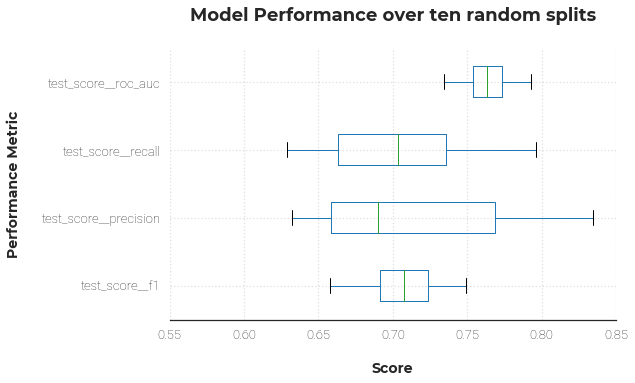

In [37]:
fig, ax = plt.subplots(figsize=(8, 5))

(df_ten_models
 .T
 .drop(['train_score', 'test_score__accuracy'], axis=1)
 .plot.box(vert=False, xlim=(0.55, 0.85), ax=ax)
);

ax.set_title("Model Performance over ten random splits\n", fontdict=font_title);
ax.set_xlabel("\nScore", fontdict=font_axes)
ax.set_ylabel("Performance Metric\n", fontdict=font_axes)


ax.grid(True, linestyle=":", alpha=0.6)

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig("reports/figures/01-model-performance-LR.png", bbox_inches='tight', pad_inches=0.5)
;

In [38]:
df_ten_models.round(2).T

,test_score__accuracy,test_score__f1,test_score__precision,test_score__recall,test_score__roc_auc,train_score
split_0,0.78,0.72,0.79,0.66,0.76,0.84
split_1,0.76,0.66,0.66,0.66,0.74,0.85
split_2,0.79,0.70,0.78,0.63,0.76,0.84
split_3,0.74,0.67,0.63,0.71,0.73,0.85
split_4,0.78,0.73,0.71,0.74,0.77,0.84
split_5,0.81,0.75,0.83,0.68,0.79,0.84
split_6,0.78,0.72,0.74,0.70,0.76,0.85
split_7,0.76,0.69,0.66,0.72,0.75,0.84
split_8,0.78,0.73,0.67,0.80,0.79,0.83
split_9,0.77,0.70,0.64,0.77,0.77,0.84


In [40]:
choice = int(input("Pick a split number from the table above.\nValid entries (0-9)\n"))
SELECTED_MODEL = [i for i in list_models][choice]
gscv = SELECTED_MODEL.get('model')

print("GridSearch Results...\n")
(DataFrame(gscv.cv_results_)
 .set_index('params')
 .loc[:, ['mean_test_score', 'mean_fit_time']]
 .sort_values('mean_test_score', ascending=False)
 .round(2)
 .head()
)

GridSearch Results...



/Users/dkhosla/miniconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/dkhosla/miniconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/dkhosla/miniconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwarg

,mean_test_score,mean_fit_time
params,,
"{'model__C': 10, 'model__class_weight': 'balanced', 'model__penalty': 'l1'}",0.85,0.01
"{'model__C': 10, 'model__class_weight': 'balanced', 'model__penalty': 'l2'}",0.85,0.00
"{'model__C': 1, 'model__class_weight': 'balanced', 'model__penalty': 'l2'}",0.85,0.00
"{'model__C': 1, 'model__class_weight': 'balanced', 'model__penalty': 'l1'}",0.85,0.00
"{'model__C': 0.1, 'model__class_weight': 'balanced', 'model__penalty': 'l2'}",0.85,0.00


In [41]:
SELECTED_MODEL.get('model').best_estimator_.named_steps.get('model').get_params()

{'C': 10,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [42]:
Series(SELECTED_MODEL.get('model').best_estimator_.named_steps.get('model').coef_[0].round(3),
       index=X.columns).round(2).sort_values()

age                    -0.55
cabinnumber__is_null   -0.40
pclass_3               -0.39
sibsp                  -0.32
age__is_null           -0.11
fare__is_null          -0.08
parch                  -0.07
fare                   -0.02
embarked_S             -0.02
embarked_Q              0.00
pclass_2                0.00
embarked__is_null       0.13
embarked_C              0.13
pclass_1                0.28
gender                  1.30
dtype: float64

# Grid Search for Decision Trees

In [43]:
pipe_dt = \
Pipeline([
    ('scale', StandardScaler()),
    ('select', SelectKBest(score_func=f_classif)),
    ('model', DecisionTreeClassifier())
])

grid_dt = {
    'select__k': [5, 9, 'all'],
    'model__max_depth':[3, 5, 7],
    'model__min_samples_split': [20, 40, 80],
    'model__class_weight': ['balanced', None]
}

/Users/dkhosla/miniconda2/envs/py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [5] are constant.
  UserWarning)
/Users/dkhosla/miniconda2/envs/py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/dkhosla/miniconda2/envs/py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [5] are constant.
  UserWarning)
/Users/dkhosla/miniconda2/envs/py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/dkhosla/miniconda2/envs/py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [5] are constant.
  UserWarning)
/Users/dkhosla/miniconda2/envs/py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate

,split_0,split_1,split_2,split_3,split_4,split_5,split_6,split_7,split_8,split_9
test_score__accuracy,0.78,0.81,0.82,0.77,0.79,0.80,0.83,0.81,0.82,0.77
test_score__f1,0.73,0.72,0.72,0.67,0.71,0.74,0.76,0.70,0.70,0.65
test_score__precision,0.64,0.83,0.72,0.74,0.76,0.77,0.79,0.73,0.76,0.64
test_score__recall,0.86,0.63,0.72,0.61,0.67,0.72,0.73,0.67,0.66,0.67
test_score__roc_auc,0.80,0.77,0.79,0.74,0.77,0.78,0.81,0.78,0.78,0.74
train_score,0.83,0.84,0.84,0.85,0.85,0.85,0.82,0.84,0.85,0.84


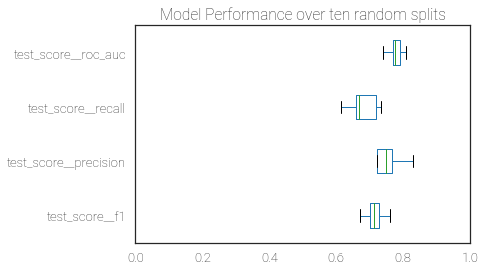

In [45]:
# ---------------------------------------------------------------
# RUN GRID SEARCHES OVER 10 RANDOM SPLITS
# ---------------------------------------------------------------

list_models = \
map(lambda i:
    run_classifier(
        X=X, 
        y=y,
        UNCORR=X.columns.tolist(),
        TEST_SIZE=0.2,
        CLF=pipe_dt, 
        GRID=grid_dt, 
        SCORING='roc_auc'),
    range(10))

df_ten_models = \
(pd.concat(
    map(lambda model:
        Series({k:model[k] for k in model.keys() if 'score' in k}), list_models),
    axis=1))

df_ten_models.columns = map(lambda i: 'split_{}'.format(i), df_ten_models)
df_ten_models.round(2)

# ---------------------------------------------------------------
# PERFORMANCE ANALYSIS
# ---------------------------------------------------------------

(df_ten_models
 .T
 .drop(['train_score', 'test_score__accuracy'], axis=1)
 .plot.box(vert=False, title="Model Performance over ten random splits", xlim=(0, 1))
);

df_ten_models.round(2)

In [ ]:
# ---------------------------------------------------------------
# FINAL MODEL
# ---------------------------------------------------------------

choice = int(raw_input("Pick a split number from the table above.\nValid entries (0-9)\n"))
SELECTED_MODEL = list_models[choice]
gscv = SELECTED_MODEL.get('model')

print "GridSearch Results...\n"
(DataFrame(gscv.cv_results_)
 .set_index('params')
 .loc[:, ['mean_train_score', 'mean_test_score', 'mean_fit_time']]
 .sort_values('mean_test_score', ascending=False)
 .round(2)
 .head()
)

In [ ]:
SELECTED_MODEL.get('model').best_estimator_.named_steps.get('model')

In [ ]:
Series(SELECTED_MODEL.get('model').best_estimator_.named_steps.get('model').feature_importances_,
       index=X.columns.tolist()).round(2).sort_values(ascending=False)

In [ ]:
import joblib

with open('joblib-gscv', 'wb') as fo:  
    joblib.dump(gscv_lr, fo)

with open('joblib-gscv', 'rb') as fo:  
    gscv_2 = joblib.load(fo)